<a href="https://colab.research.google.com/github/wolfisberg/zhaw-ba-online/blob/main/lstm_offline/lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preparation

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
data_folder = '/content/drive/MyDrive/BA_2021/tfrecords'

In [3]:
import shutil
import os

data_folder_local = '/content'
if not os.path.exists(data_folder_local):
    os.mkdir(data_folder_local)
shutil.copytree(data_folder, os.path.join(data_folder_local, 'data', 'tfrecords'))
data_folder = os.path.join(data_folder_local, 'data', 'tfrecords')

In [5]:
import datetime
import os

import numpy as np
import tensorflow as tf
import scipy.interpolate
import matplotlib.pyplot as plt
%load_ext tensorboard


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [6]:
config = {}
config['batch_size'] = 64
config['SNR_range'] = (-5.0,20.0) #dB
config['frame_length'] = 512
config['frame_step'] = 256
config['min_rand_gain'] = 0.05
config['max_rand_gain'] = 1.1
config['sample_length'] = 3 #shorter than shortest noise/speech sample
config['fs'] = 16000
config['num_frames'] = 1 + (config['fs']*config['sample_length'] - config['frame_length']) // config['frame_step']
config['pitch_sampling_time'] = 0.01 # s
config['pitch_confidence_threshold'] = 0.15
config['pitch_frame_length'] = 0.032 # s
seed = 2

In [7]:
parsing_config_noise = {
        'data': tf.io.VarLenFeature(tf.string),
        'data_sampling_rate': tf.io.VarLenFeature(tf.int64),
        'data_num_channels': tf.io.VarLenFeature(tf.int64),
        'data_width': tf.io.VarLenFeature(tf.int64),
        }

def parse_noise_record(serialized_example):
    parsed_features = tf.io.parse_single_example(
        serialized_example, features=parsing_config_noise
    )

    decoded_features = {
        "data_num_channels": tf.cast(parsed_features["data_num_channels"].values[0], tf.int32),
        "data_sampling_rate": tf.cast(parsed_features["data_sampling_rate"].values[0], tf.int32),
        "data_width": tf.cast(parsed_features["data_width"].values[0], tf.int32),
    }
    data = tf.io.decode_raw(parsed_features['data'].values[0], tf.int16)
    decoded_features.update({"data": data})
    return decoded_features

parsing_config_speech = {
        'data': tf.io.VarLenFeature(tf.string),
        'data_sampling_rate': tf.io.VarLenFeature(tf.int64),
        'data_num_channels': tf.io.VarLenFeature(tf.int64),
        'data_width': tf.io.VarLenFeature(tf.int64),
        'pitch': tf.io.VarLenFeature(tf.float32),
        'pitch_confidence': tf.io.VarLenFeature(tf.float32),
        }

def parse_speech_record(serialized_example):
    parsed_features = tf.io.parse_single_example(
        serialized_example, features=parsing_config_speech
    )

    decoded_features = {
        "data_num_channels": tf.cast(parsed_features["data_num_channels"].values[0], tf.int32),
        "data_sampling_rate": tf.cast(parsed_features["data_sampling_rate"].values[0], tf.int32),
        "data_width": tf.cast(parsed_features["data_width"].values[0], tf.int32),
        "pitch": tf.cast(parsed_features['pitch'].values, tf.float32),
        "pitch_confidence": tf.cast(parsed_features['pitch_confidence'].values, tf.float32),
    }
    data = tf.io.decode_raw(parsed_features['data'].values[0], tf.int16)
    decoded_features.update({"data": data})
    return decoded_features

In [8]:
def mix_noisy_speech(speech, noise):   
    speech_pow = tf.math.reduce_euclidean_norm(speech)
    noise_pow = tf.math.reduce_euclidean_norm(noise)

    min_SNR = config['SNR_range'][0]
    max_SNR = config['SNR_range'][1]
    snr_current = 20.0*tf.math.log(speech_pow/noise_pow)/tf.math.log(10.0)
    snr_target = tf.random.uniform((),minval=min_SNR,maxval=max_SNR)

    noise = noise * tf.math.pow(10.0,(snr_current-snr_target)/20.0)
    noisy_speech = speech+noise

    return speech, noise, noisy_speech

In [9]:
def interpolate_pitch(pitch,t):
    pitch = pitch.numpy()
    t = t.numpy()
    t_pitch = np.arange(0, len(pitch))*config['pitch_sampling_time']+config['pitch_frame_length']/2
    f = scipy.interpolate.interp1d(t_pitch, pitch, 'nearest')
    return f(t).astype(np.float32)

@tf.function
def interpolate_pitch_tf(pitch,t):
    y = tf.py_function(interpolate_pitch,[pitch,t], Tout=tf.float32)
    return tf.squeeze(y)


In [10]:
def calc_features(speech_data, noise_data):
    speech = tf.squeeze(tf.cast(speech_data["data"],tf.float32))
    noise = tf.squeeze(tf.cast(noise_data["data"],tf.float32))
    speech = speech/tf.int16.max
    noise = noise/tf.int16.max

    random_start_idx = int(tf.round(tf.random.uniform([],maxval=(tf.cast(len(noise),tf.float32)-config['sample_length']*config['fs']-config['pitch_sampling_time']))))
    noise = noise[random_start_idx:random_start_idx+config['sample_length']*config['fs']]

    random_start_idx = int(tf.round(tf.random.uniform([],minval=161,maxval=(tf.cast(len(speech),tf.float32)-config['sample_length']*config['fs']-161))))
    speech = speech[random_start_idx:random_start_idx+config['sample_length']*config['fs']]

    SNR_range = config['SNR_range']
    frame_length = config['frame_length']
    frame_step = config['frame_step']
    speech, noise, noisy = mix_noisy_speech(speech, noise)
    
    random_gain = tf.math.exp(tf.random.uniform([],minval=tf.math.log(config['min_rand_gain']),maxval=tf.math.log(config['max_rand_gain'])))
    noisy = random_gain*noisy
    
    noisy_frames = tf.signal.frame(noisy,frame_length,frame_step)
    #noisy_stft = tf.signal.stft(noisy,frame_length,frame_step)
    frame_times = random_start_idx/config['fs']+tf.range(0,config['num_frames'])*frame_step/config['fs']+frame_length/config['fs']
   
    
    pitch = tf.squeeze(speech_data["pitch"])
    pitch_confidence = tf.squeeze(speech_data["pitch_confidence"])
    #pitch = tf.where(pitch_confidence>config['pitch_confidence_threshold'],pitch,0)
    pitch_interpolated = interpolate_pitch_tf(pitch,frame_times)
    return noisy_frames, pitch_interpolated



# Dataset

In [11]:
speech_data_folder = os.path.join(data_folder,'speech', 'tr')
noise_data_folder = os.path.join(data_folder,'noise', 'tr')

speech_ds = tf.data.TFRecordDataset([os.path.join(speech_data_folder,file) for file in os.listdir(speech_data_folder)])
speech_ds = speech_ds.map(parse_speech_record).repeat(None).shuffle(buffer_size=1000, seed=seed)

noise_ds = tf.data.TFRecordDataset([os.path.join(noise_data_folder,file) for file in os.listdir(noise_data_folder)])
noise_ds = noise_ds.map(parse_noise_record).repeat(None).shuffle(buffer_size=1000, seed=seed)


dataset_combined = tf.data.Dataset.zip((speech_ds, noise_ds))
dataset_features = dataset_combined.map(calc_features, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset_features = dataset_features.batch(config['batch_size'], drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)

dataset_training = dataset_features


In [12]:
speech_data_folder = os.path.join(data_folder,'speech', 'tt')
noise_data_folder = os.path.join(data_folder,'noise', 'tt')

speech_ds = tf.data.TFRecordDataset([os.path.join(speech_data_folder,file) for file in os.listdir(speech_data_folder)])
speech_ds = speech_ds.map(parse_speech_record).repeat(None).shuffle(buffer_size=1000, seed=seed)

noise_ds = tf.data.TFRecordDataset([os.path.join(noise_data_folder,file) for file in os.listdir(noise_data_folder)])
noise_ds = noise_ds.map(parse_noise_record).repeat(None).shuffle(buffer_size=1000, seed=seed)


dataset_combined = tf.data.Dataset.zip((speech_ds, noise_ds))
dataset_features = dataset_combined.map(calc_features, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset_features = dataset_features.batch(config['batch_size'], drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)

dataset_test = dataset_features

In [13]:
speech_data_folder = os.path.join(data_folder,'speech', 'cv')
noise_data_folder = os.path.join(data_folder,'noise', 'cv')

speech_ds = tf.data.TFRecordDataset([os.path.join(speech_data_folder,file) for file in os.listdir(speech_data_folder)])
speech_ds = speech_ds.map(parse_speech_record).repeat(None).shuffle(buffer_size=1000, seed=seed)

noise_ds = tf.data.TFRecordDataset([os.path.join(noise_data_folder,file) for file in os.listdir(noise_data_folder)])
noise_ds = noise_ds.map(parse_noise_record).repeat(None).shuffle(buffer_size=1000, seed=seed)


dataset_combined = tf.data.Dataset.zip((speech_ds, noise_ds))
dataset_features = dataset_combined.map(calc_features, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset_features = dataset_features.batch(config['batch_size'], drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)

dataset_validation = dataset_features


# LSTM

In [ ]:
def custom_metric(pitch_true, pitch_pred):
    print(pitch_true.shape)
    for i in range(len(pitch_true)):
        pitch_ref = mir_eval.melody.hz2cents(outp[i], base_frequency=10.0)
        pitch_est = mir_eval.melody.hz2cents(pred[i], base_frequency=10.0)
        error = raw_pitch_accuracy(pitch_ref=pitch_ref, pitch_est=pitch_est)
        summed_error += error
    errors.append(summed_error / len(pred))
    return np.mean(errors)
    
def raw_pitch_accuracy(pitch_true, pitch_pred):
    counter_true = 0
    counter_false = 0
    
    for i in range(len(pitch_ref)):
        if abs(pitch_pred[i] - pitch_true[i]) <= 50.0:
            counter_true += 1
        else:
            counter_false += 1
        
    result = counter_true / (counter_true + counter_false) * 100
    return result

In [14]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(256,return_sequences=True, input_shape=(config['num_frames'], config['frame_length'])))
model.add(tf.keras.layers.LSTM(256, return_sequences=True))
#model.add(tf.keras.layers.Dropout(0.6))
model.add(tf.keras.layers.Dense(128,activation='relu'))
model.add(tf.keras.layers.Dense(1,activation='relu'))
model.compile(loss='mse', optimizer='adam', metrics=['mse'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 186, 256)          787456    
_________________________________________________________________
lstm_1 (LSTM)                (None, 186, 256)          525312    
_________________________________________________________________
dense (Dense)                (None, 186, 128)          32896     
_________________________________________________________________
dense_1 (Dense)              (None, 186, 1)            129       
Total params: 1,345,793
Trainable params: 1,345,793
Non-trainable params: 0
_________________________________________________________________


In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

# Luca's Try

In [ ]:
from tensorflow.keras import layers
from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv1D, ReLU, BatchNormalization,\
                                    AveragePooling1D, Flatten, Dense, Reshape
from tensorflow.keras.models import Model

In [ ]:
def resblock(x, filters, kernelsize, dilationrate):
    fx = layers.Conv1D(filters, kernelsize,strides=1, dilation_rate=dilationrate, activation='relu', padding='same')(x)
    fx = layers.BatchNormalization()(fx)
    fx = layers.Conv1D(filters, kernelsize, padding='same')(fx)
    out = layers.Add()([x,fx])
    out = layers.ReLU()(out)
    #out = layers.BatchNormalization()(out)
    return out

In [ ]:
def create_cnn():
    inputs = Input(shape=(config['num_frames'], config['frame_length']))
    #inputs = Input(shape=(1024, 512))
    #inputs = Reshape(target_shape=(186, 512, 1))(inputs)
    #t = BatchNormalization()(inputs)
    t = Conv1D(filters=128, kernel_size=(64), padding='same')(inputs)
    dilation_rate_list = [1, 2, 4, 8]
    for i in range(len(dilation_rate_list)):
        dilation_rate = dilation_rate_list[i]
        t = resblock(t, 128, 64, dilation_rate)

    t = AveragePooling1D(64)(t)
    t = Flatten()(t)

    outputs = Dense(1, activation='sigmoid', name="classifier")(t)
    model = Model(inputs, outputs)

    model.compile(optimizer='adam', loss='binary_crossentropy')

    return model

    

In [ ]:
model = create_cnn()
model.summary()

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

# Train Model

In [ ]:
%tensorboard --logdir /content/drive/MyDrive/BA_2021/logs

In [15]:
date_time_string = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = os.path.join("/content/drive/MyDrive/BA_2021/logs", date_time_string)
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

folder = os.path.join('/content/drive/MyDrive/BA_2021/checkpoints', date_time_string)
if not os.path.exists(folder):
    os.makedirs(folder)
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(folder,'{epoch:02d}-{val_loss:.2f}.hdf5'))

callbacks = [checkpoint, tensorboard_callback]

In [ ]:
history = model.fit(dataset_training, steps_per_epoch=720, epochs=30, verbose = 1 ,validation_data = dataset_validation, validation_steps=70, callbacks = callbacks)

In [ ]:
plt.plot(history.history['loss'], label='MAE (training data)')
plt.plot(history.history['val_loss'], label='MAE (validation data)')
plt.show()

In [75]:
model.load_weights(os.path.join('/content/drive/MyDrive/BA_2021/checkpoints', '20210405-202143', '27-1726.69.hdf5'))

In [ ]:
prediction_example = next(iter(dataset_test))

In [ ]:
plt.plot(prediction_example[1][4], 'g')
plt.plot(test_prediciton[4], 'r')
plt.show()

# WAV Encoder

In [ ]:
import scipy.io.wavfile as wavf

In [ ]:
def wav_encoder(splitted_samples):
    #splittet_samples = next(iter(dataset_test))
    samples = []
    for i in range(len(splitted_samples[0][0])):
        for j in range(len(splitted_samples[0][0][0]) - config['frame_step']):
            samples = np.append(samples, splitted_samples[0][0][i][j])

    date_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    out_file = 'out_' + date_time + '.wav'
    wavf.write(out_file, config['fs'], samples)


In [ ]:
wav_encoder(next(iter(dataset_test)))

# Metrics Test

In [ ]:
!pip install mir_eval
import mir_eval

In [ ]:
test_prediction = model.predict(dataset_test, steps=1, callbacks=[PitchAccuracyCallback(dataset_test)])

## Raw Pitch Accuracy in Cents

In [19]:
!pip install mir_eval

     |████████████████████████████████| 92kB 4.2MB/s 
  Created wheel for mir-eval: filename=mir_eval-0.6-cp37-none-any.whl size=96515 sha256=5cdcfb69131ba3668b7bc401d159122e1969415a0ad1d387060aa713c634c115
  Stored in directory: /root/.cache/pip/wheels/49/ce/30/730fa72addf275e49d90683b01b3613048b4be3bf7ff8eb6ec
Successfully built mir-eval


In [20]:
import mir_eval

In [116]:
def raw_pitch_accuracy(pitch_ref, pitch_est, pitch_limit=50.0):
    pitch_limit = mir_eval.melody.hz2cents(np.array([pitch_limit]), base_frequency=10.0)
    counter_true = 0
    counter_false = 0
    counter_zero = 0
    for i in range(len(pitch_ref)):
        if abs(pitch_ref[i] >= pitch_limit[0]):
            if abs(pitch_est[i] - pitch_ref[i]) <= 50.0:
                counter_true += 1
            else:
                counter_false += 1
        if counter_true == 0.0:
            error = 0.0
        else:
            error = counter_true / (counter_true + counter_false) * 100 
    return error

In [117]:
errors = []

for inp, outp in dataset_test.take(10):
    summed_error = 0
    counter_zero = 0
    pred = model.predict(inp)
    pred = pred.reshape(outp.shape)
    for i in range(len(pred)):
        
        pitch_ref = mir_eval.melody.hz2cents(outp[i].numpy(), base_frequency=10.0)
        pitch_est = mir_eval.melody.hz2cents(pred[i], base_frequency=10.0)
        error = raw_pitch_accuracy(pitch_ref=pitch_ref, pitch_est=pitch_est)
        summed_error += error
    errors.append(summed_error / len(pred))

In [118]:
print(errors)
print(np.mean(errors))

[34.40941787491284, 37.981422639135126, 35.98677868225201, 37.901344677664206, 30.217262518391518, 34.68887357676004, 33.63855764416069, 35.098820449508494, 35.9827823041826, 35.721784655062805]
35.16270450220303


In [76]:
model.evaluate(dataset_test, steps=70)

70/70 [==============================] - 56s 742ms/step - loss: 1490.5044 - mse: 1490.5044


[1444.9935302734375, 1444.9935302734375]

In [ ]:
def raw_pitch_accuracy(pitch_ref, pitch_est):
    counter_true = 0
    counter_false = 0
    for i in range(len(pitch_ref)):
        
        
    result = counter_true / (counter_true + counter_false) * 100
    return result

In [65]:
inp, outp = next(iter(dataset_test))

In [66]:
pred = model.predict(inp)

In [ ]:
print(pred)

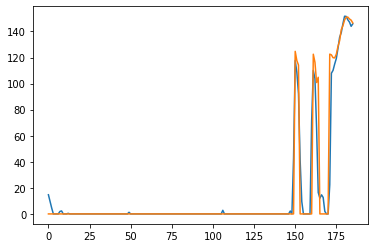

In [86]:
plt.plot(pred[30])
plt.plot(outp[30])
plt.show()

## Raw Pitch Accuracy in Hz

In [119]:
errors = []

for inp, outp in dataset_test.take(100):
    summed_error = 0
    counter_true = 0
    counter_false = 0
    pred = model.predict(inp)
    pred = pred.reshape(outp.shape)
    for i in range(len(pred)):
        pitch_ref = outp[i].numpy()
        pitch_est = pred[i]
        if pitch_ref[0] <= 50.0:
            if abs(pitch_est[i] - pitch_ref[i]) <= abs(pitch_ref[i] * 0.05):
                counter_true += 1
            else:
                counter_false += 1
        if counter_true == 0.0:
            error = 0.0
        else:
            error = counter_true / (counter_true + counter_false) * 100
        summed_error += error
    errors.append(summed_error / len(pred))

In [120]:
print(np.mean(errors))

64.44535730222864


In [126]:
pitch =  1200.0*np.log2(125/10)
pitch_est = 1200.0*np.log2(130/10)
print(pitch, pitch_est)

4372.62742772967 4440.527661769311
